### Apply PCA and K-means on Local Field Potential

In [ ]:
### clean anesthetized target 1

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import spectrogram
from scipy.io import savemat
import scipy.signal as signal
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
# h5py objects like f['data_combine_Low_downsample'] are lazy readers.
with h5py.File('data/downsampled_LFP.mat', 'r') as f:


    # This loads the entire dataset into memory in one call.
    # [:] → like NumPy slicing, only works for plain numeric datasets
    # [()] → read the entire dataset, including structured or object data
    data = f['data_combine_Low_downsample'][()]
    print(data.shape)
    print(data[:,0])

(4968346, 32)
[-1.29825076e-05 -1.32193337e-04 -1.92798185e-04 ...  4.27022874e-05
  4.30599057e-05  4.31086802e-05]


In [4]:
# Notch filter

# An IIR filter (Infinite Impulse Response filter) is a type of digital filter that uses both:
# Current and past inputs (like FIR filters), and
# Past outputs (feedback) to compute the current output.
# This makes the filter's impulse response theoretically infinite — hence the name.

def create_notch_filter(fs, f0, Q):
    """
    Create a digital notch filter to remove 60Hz noise
    
    Parameters:
    fs : float
        Sampling frequency in Hz
    f0 : float
        Notch frequency (default 60Hz)
    Q : float
        Quality factor (higher Q = narrower notch)
        
    Returns:
    b, a : ndarray
        Numerator and denominator polynomials of the IIR filter
    """
    # Normalize notch frequency by Nyquist frequency
    w0 = f0/(fs/2)
    
    # Create the notch filter
    b, a = signal.iirnotch(w0, Q)
    
    return b, a

In [5]:
# low pass filter
def lowpass_filter(data, fs, cutoff=40, order=6):
    # order: determines how steep the filter is (higher = sharper transition)
    # A low-pass filter passes (keeps) frequencies below the cutoff.
    # It attenuates (reduces) frequencies above the cutoff.
    """

    Apply a low-pass Butterworth filter to the input signal.

    Parameters:
    ----------
    data : array_like
        The input signal data to be filtered.
    fs : float
        The sampling frequency of the signal in Hz.
    cutoff : float, optional
        The cutoff frequency of the filter in Hz. Defaults to 40 Hz.
    order : int, optional
        The order of the Butterworth filter. Higher order means a sharper roll-off. Defaults to 6.

    Returns:
    -------
    filtered_data : ndarray
        The filtered signal, with high frequencies attenuated.
    """

    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    
    # .filtfilt is a function from scipy.signal that applies a zero-phase filter to your data by
    # running the filter forward and then backward.
    return signal.filtfilt(b, a, data)
    


In [7]:
sampling_rate = 24414.0625 / 20  # 1220.703125 Hz
b, a = create_notch_filter(sampling_rate, f0=60.0, Q=30)
    
filtered_data = np.zeros_like(data)
sig_data = np.zeros_like(data)
# number of channels 
for ch in range(data.shape[1]):
    # Select all rows (i.e., all time samples) from column ch (i.e., channel ch) of the data array
    notch_applied = signal.lfilter(b, a, data[:, ch])
    filtered_data[:, ch] = lowpass_filter(notch_applied, sampling_rate)

    # Savitzky–Golay filter
    # Savitzky–Golay smoothing is ideal when you want to reduce noise but still retain the original shape of the signal
    # Fits a low-degree polynomial to a sliding window of data points using least squares,
    # and replaces the center point with the predicted value from that polynomial.
    sig_data[:, ch] = savgol_filter(filtered_data[:, ch], window_length=31, polyorder=3)
print(sig_data[:,0])
print(sig_data.shape)

[-8.59086450e-06 -2.24712599e-05 -3.53881020e-05 ...  1.03051852e-05
  1.69903346e-05  2.44814330e-05]
(4968346, 32)


In [8]:
trial_data = loadmat('data\trial_info.mat')

In [11]:
trial_data['trialinfo'].shape

(1, 2)

In [13]:
# That means every element in trial_data['trialinfo'] is a record with two named fields
trial_data['trialinfo'].dtype.names

('TSClean', 'TSMasked')

In [14]:
trial_data['trialinfo'][0]['TSClean'].shape

(2,)

In [19]:
trial_data['trialinfo'][0]['TSClean'].shape

(2,)

In [20]:
trial_data['trialinfo'][0, 0]['TSClean'].shape

(4, 2)

In [16]:
trial_data['trialinfo'][0, 0]['TSClean']

array([[array([[ 142.03301215],
               [ 287.032938  ],
               [ 477.03284073],
               [ 627.03276372],
               [ 972.03258729],
               [1162.03249002],
               [1217.03246164],
               [1412.03236198],
               [1642.03224421],
               [1812.03215718]]), array([[ 102.03303266],
                                         [ 357.032902  ],
                                         [ 442.03285861],
                                         [ 767.03269219],
                                         [ 922.0326128 ],
                                         [1077.03253341],
                                         [1212.03246427],
                                         [1422.03235674],
                                         [1787.03216982],
                                         [1857.03213406]])],
       [array([[ 157.03300452],
               [ 282.03294039],
               [ 582.03278685],
               [ 802.03267431],
 

In [22]:
trial_info = trial_data['trialinfo'][0, 0]['TSClean']
len([trial_info[i][0] for i in range(4)])

4

In [31]:
fs = 24414.0625 / 20         
four_angle_dict = {}       # key: four angles   value: 10 timestamps for each angle
angle_trial_blocks = [trial_info[i][0] for i in range(4)]

for i in range(len(angle_trial_blocks)):

    ch_dict = {}  # dict with key of 32 channels and the corresponding segments on the signal
    trial_timestamps = angle_trial_blocks[i].T 
    print(trial_timestamps)
    for ch in range(sig_data.shape[1]):
        channel_data = sig_data[:, ch]       # with the shape of (4968346, 32)
        indices = [(int((int(arr)-1)*fs), int((int(arr)+4)*fs)) for arr in trial_timestamps[0]]
        epoch_segments = [channel_data[start: stop] for (start, stop) in indices]      # 10 items
        print(len(epoch_segments))
        ch_dict[ch+1] = epoch_segments
    four_angle_dict[i+1] = ch_dict
print(len(four_angle_dict[4]))    
print(len(four_angle_dict[4][1]))

[[ 142.03301215  287.032938    477.03284073  627.03276372  972.03258729
  1162.03249002 1217.03246164 1412.03236198 1642.03224421 1812.03215718]]
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
[[ 157.03300452  282.03294039  582.03278685  802.03267431  882.0326333
  1092.03252578 1257.03244138 1552.03229022 1682.0322237  1922.03210068]]
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
[[  37.0330658   367.032897    532.03281236  607.03277397  857.03264618
  1172.03248477 1367.03238487 1492.03232098 1772.03217769 1987.03206754]]
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
[[ 162.0330019   372.03289437  517.03282022  752.03269982  887.03263068
  1132.03250527 1207.03246689 1482.03232598 1767.03218007 1957.0320828 ]]
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
32
10


In [7]:
trial_data = loadmat('data/trial_info.mat')
trial_info = trial_data['trialinfo'][0, 0][1]

class Signal:
    
    """
    A class to represent and process neural signal data associated with specific trial conditions.

    Attributes:
        sig_data (any): The raw signal data, typically a NumPy array with the shape of (4968346, 32)
        trial_data (dict): Trial information loaded from a .mat file.
        condition (str): 'TSClean', 'TSMasked'
        trial_row (int): Row index for accessing trial data(only has 0, just one row).
        trial_column (int): Column index for accessing trial data(contain 0 and 1, two column: awake and anethetized).
        trial_idx (int): target 1 or target 2.
        fs (float): Sampling frequency of the signal (default is 1220.703125 Hz).
    """
    #Storing constants and configuration values inside the class, rather than defining them as global variables.
    def __init__(self, sig_data, trial_data, condition, trial_row, trial_column, trial_idx, fs = 24414.0625 / 20):
        
        """
        Initialize the Signal object with signal and trial data.

        Args:
            sig_data (ndarray): Array of signal recordings with the shape of (4968346, 32).
            trial_data (dict): Trial metadata loaded from a .mat file.
            condition (str): 'TSClean', 'TSMasked'
            trial_row (int): Row index for accessing trial data(only has 0, just one row).
            trial_column (int): Column index for accessing trial data(contain 0 and 1, two column: awake and anethetized)
            trial_idx (int): target 1 or target 2.
            fs (float, optional): Sampling frequency of the signal. Defaults to 24414.0625 / 20.
        """
        self.sig_data = sig_data
        self.trial_data = trial_data
        self.condition = condition
        self.trial_row = trial_row
        self.trial_column = trial_column
        self.trial_idx = trial_idx
        self.fs = fs
        
        
    def slicing_and_concatenate(self):
        """
        Extracts and concatenates trial onset timestamps in trial_data
        
        trial_info: with the shape of (4, 2)

        Returns:
            np.ndarray: A 1D array of concatenated onset times from 4 angles with the specific trial_idx either target 1 or
            target 2.           .
        """
        trial_info = self.trial_data['trialinfo'][self.trial_row, self.trial_column][self.condition]
        angle_trial_blocks = [trial_info[i][self.trial_idx] for i in range(4)]    # 10 timestamps for each angle; 4 angles 


        return angle_trial_blocks # a list of four list each representing an angle
        
        
    def channel_dict_buildup(self):
        
        
        """
        Builds a dictionary containing LFP signal segments per channel, sliced using
        the onset timestamps extracted from the trial data.

        Each key in the dictionary corresponds to a channel (1 to 32), and each value is a list of
        signal segments (from -1s to +4s around each onset) for that channel.

        Returns:
            dict: Dictionary of the form {{angle: {channel_number: a list of 10 signal segments}}}
        """
        
        four_angle_dict = {}       # key: four angles   value: a dict with the key of 32 channels; each channel has 10 timestamps
        angle_trial_blocks = self.slicing_and_concatenate()
   
        for i in range(len(angle_trial_blocks)):    # iterate through each angle 

            ch_dict = {}  # dict with key of 32 channels and the corresponding segments on the signal
            trial_timestamps = angle_trial_blocks[i].T 
            for ch in range(self.sig_data.shape[1]):
                channel_data = self.sig_data[:, ch]       # with the shape of (4968346, 32)
                indices = [(int((int(arr)-1)*self.fs), int((int(arr)+4)*self.fs)) for arr in trial_timestamps[0]]
                epoch_segments = [channel_data[start: stop] for (start, stop) in indices]      # 10 items in each angle
                ch_dict[ch+1] = epoch_segments
            four_angle_dict[i+1] = ch_dict
        return four_angle_dict
         
    def get_grand_mean_signal(self):
        """
        Calculate the grand mean of signal
        
        loop through each angle and each channel, find out the minimum length in the ten signal segments, truncate ten segments into the 
        same length, sum them up and take the average
        
        Having mean signal for each channel and then average them to get the grand mean for 32 channel
        
        
        Returns:
            dict: each angle has the average of mean signal for 32 channels
        """

        
        four_angle_dict = self.channel_dict_buildup()
        
        four_mean_signal_dict = {}  # key: four angles    value: grand mean 
        
        mean_signal_sample = {}     #  key: four angles   value: each key has 32 mean signals
        
        for angle in four_angle_dict.keys():  
            mean_signal_sample[angle] = []
            grand_signal = None
            grand_mean_signal =None
            
            for ch_num in four_angle_dict[angle].keys():
                min_length = min(arr.shape[0] for arr in four_angle_dict[angle][ch_num])

                
                trimmed_lst = [arr[:min_length] for arr in four_angle_dict[angle][ch_num]]   # 10 items
                summed_signal = np.sum(trimmed_lst, axis=0)
                mean_signal = summed_signal/len(trimmed_lst)    # 10 times  10 segment in each channel
                mean_signal_sample[angle].append(mean_signal)   # each key has 32 mean signals
                if grand_signal is None:
                    grand_signal = np.zeros_like(mean_signal)
                grand_signal += mean_signal                 # 32 times

            if grand_mean_signal is None:
                grand_mean_signal = grand_signal/len(four_angle_dict[angle])   

            four_mean_signal_dict[angle] = grand_mean_signal

        return four_mean_signal_dict, mean_signal_sample
    
    
    def to_get_standard_deviation(self):
        """
        get mean_signal_sample and then calculate the standard deviation for each angle
        
        returns: 
            dict:key: each angle; value: standard deviation 
        """
        
        std_signal = {}  # dict contain std for each angle (four in total)
        
        
        mean_signal_sample = self.get_grand_mean_signal()[1]
        
        for angle in mean_signal_sample.keys():
            std_signal[angle]=np.std(mean_signal_sample[angle])
        return std_signal
                               
    def plot_grand_mean_signal(self, ylim=(-0.0006,0.0006)):
    """
    Plot the grand mean signals for four angles with ±1 standard deviation shading.

    This function visualizes the grand mean signal over time for each of the four angles
    (assumed to be stored in a dictionary format). It overlays the standard deviation as a 
    shaded area to illustrate signal variability.
    """
        
        fig, axes = plt.subplots(4, 1, figsize=(10, 8))
        four_mean_signal_dict = self.get_grand_mean_signal()[0]
        std_signal = self.to_get_standard_deviation()
        
        duration = 5 
        samples = int(duration * self.fs)

        time_axis = np.arange(samples) / self.fs 

   
        
        
        for i,  signal in enumerate(four_mean_signal_dict.values()):

            axes[i].plot(time_axis, signal)
            
            
                    # Plot shaded area for std
            axes[i].fill_between(time_axis,
                                 signal - std_signal[i+1],
                                 signal + std_signal[i+1],
                                 color='gray',
                                 alpha=0.6,
                                 label='±1 STD')
            
            axes[i].set_title('Angle ' + str(i+1))
            axes[i].set_xticks(np.linspace(0, 5, 6))
            axes[i].set_xticklabels(['-1', '0', '1', '2', '3', '4'])
            axes[i].set_xlim(0, 5)
            axes[i].legend()
            axes[i].set_ylim(ylim)
            
        plt.tight_layout()
        plt.show()
        

In [8]:
# option 1
class PCA_option_1:
    
    def __init__(self, four_angle_dict, arbi_angle_1, arbi_angle_2, num_channels):
        self.four_angle_dict = four_angle_dict
        self.angle_1 = arbi_angle_1
        self.angle_2 = arbi_angle_2
        self.number_channels = num_channels 
        
    def to_get_signal_for_specific_angle(self):
        

        # Angle 1 
        min_length_1 = min(epoch.shape[0] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_1][i])
   
        signal_1 = np.array([epoch[:min_length_1] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_1][i]])
        signal_1 = signal_1.reshape(10, -1)
  

        # Angle 2
        min_length_2 = min(epoch.shape[0] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_2][i])
 
        signal_2 = np.array([epoch[:min_length_2] for i in range(1, self.number_channels+1) for epoch in self.four_angle_dict[self.angle_2][i]])
        signal_2 = signal_2.reshape(10, -1)
 
        return signal_1, signal_2



    def to_fit_PCA_on_combined_data_and_split(self):
        
        signal_1, signal_2 = self.to_get_signal_for_specific_angle()
        # Fit PCA on combined data (recommended)
        X_combined = np.vstack([signal_1, signal_2])
        #print(X_combined.shape)
        pca = PCA(n_components=3)
        X_combined_reduced = pca.fit_transform(X_combined)

        #print(X_combined_reduced.shape)


        # Split back
        X1_reduced = X_combined_reduced[:10]
        X2_reduced = X_combined_reduced[10:]

        #print(X1_reduced.shape)
        #print(X2_reduced.shape)
        return X1_reduced, X2_reduced, X_combined_reduced
        
    def to_plot_3D_scatter(self):
        
        X1_reduced, X2_reduced = self.to_fit_PCA_on_combined_data_and_split()[:2]
        # 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(*X1_reduced.T, color='blue', label='angle '+ str(self.angle_1), s=20)
        ax.scatter(*X2_reduced.T, color='orange', label='angle '+str(self.angle_2), s=20)

        ax.set_title(f"PCA Projection ({self.number_channels} Channels per Signal)")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.legend()
        plt.show()
        
        
    def to_apply_KMean(self):
        # Apply K-means clustering
        X1_reduced, X2_reduced, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        
        # Creates a KMeans object from scikit-learn.
        # n_clusters=2`: You want to find 2 clusters (corresponding to your 2 angles).
        # n_init=10`: The algorithm will run 10 times with different centroid seeds and return the best result.
        # random_state=0`: Ensures reproducibility (same clustering every time you run the code)
        kmeans = KMeans(n_clusters=2, n_init=10,random_state=0)
        
        # fit_predict() is a shorthand that:
        # Fits the KMeans model to the data (i.e., finds centroids).
        # Predicts the cluster label (either 0 or 1 in your case) for each sample.
        # The result labels is a NumPy array of length equal to the number of data points, assigning each point to one of the 2 clusters.
        labels = kmeans.fit_predict(X_combined_reduced)
        #print(labels)
        # Optional: true labels (for visual comparison only, not used by K-means)
        true_labels = np.array([0]*len(X1_reduced) + [1]*len(X2_reduced))
        


        acc_1 = accuracy_score(true_labels, labels)
        acc_2 = accuracy_score(true_labels, 1 - labels)  # flip 0↔1
        accuracy = max(acc_1, acc_2)
        #print(f"K-means Accuracy: {accuracy:.2f}")
        
        return accuracy,labels 

    def to_plot_KMean(self):
        _, _, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        _,labels = self.to_apply_KMean()
        # Plot in 3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        # alpha=0.8 makes points semi-transparent
        ax.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], X_combined_reduced[:, 2], c=labels, cmap='coolwarm', alpha=0.8)
        ax.set_title(f"K-means Clustering in {self.number_channels} channels")
        plt.show()
        

In [9]:
four_angle_dict = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).channel_dict_buildup()

[0.5, 0.6, 0.55, 0.5, 0.75, 0.65, 0.55, 0.55, 0.55, 1.0, 0.55, 0.5, 0.55, 0.55, 0.75, 0.6, 0.55, 0.6, 0.55, 1.0, 0.55, 0.6, 0.55, 0.6, 0.75, 0.5, 0.5, 0.5, 0.55, 1.0, 0.5, 0.5]


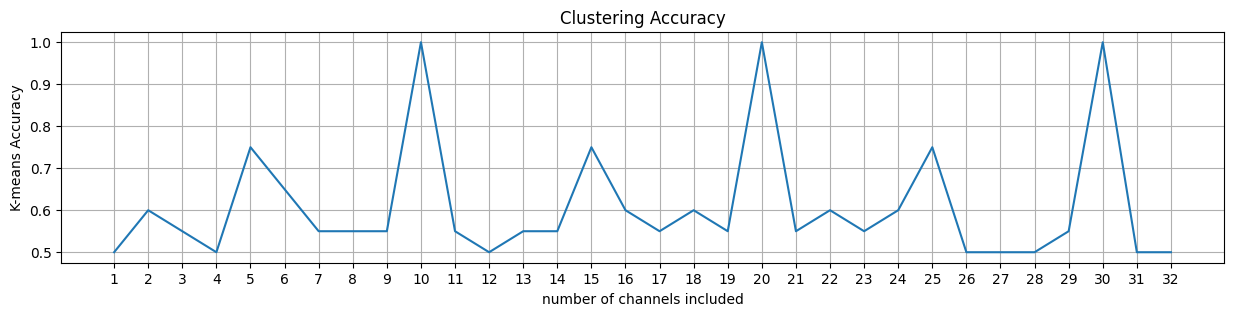

In [10]:
acc_cluster = []
for ch in range(32):
    acc = PCA_option_1(four_angle_dict, 1, 4, ch+1).to_apply_KMean()[0]
    acc_cluster.append(acc)
print(acc_cluster)

plt.figure(figsize=(15, 3)) 
plt.plot(range(1, 33), acc_cluster)
plt.xticks(range(1, 33))  # Tick every 1 unit from 1 to 32
plt.xlabel('number of channels included')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy')
plt.grid(True)
plt.show()  

In [81]:
# option 2
class PCA_option_2:
    
    def __init__(self, mean_signal_sample, arbi_angle_1, arbi_angle_2, num_channels):
        self.mean_signal_sample = mean_signal_sample
        self.angle_1 = arbi_angle_1
        self.angle_2 = arbi_angle_2
        self.number_channels = num_channels 
        
    def to_get_signal_for_specific_angle(self):
        

        # Angle 1 on channel 1-10

        min_length_1 = min(self.mean_signal_sample[self.angle_1][i].shape[0] for i in range(self.number_channels))
        #print(min_length_1)
        signal_1 = np.array([self.mean_signal_sample[self.angle_1][i][:min_length_1] for i in range(self.number_channels)])

        #print(signal_1.shape)

        # angle 4 on channel 1-10
        min_length_2 = min(self.mean_signal_sample[self.angle_2][i].shape[0] for i in range(self.number_channels))
        #print(min_length_2)
        signal_2 = np.array([self.mean_signal_sample[self.angle_2][i][:min_length_2] for i in range(self.number_channels)])

        return signal_1, signal_2
    

    def to_fit_PCA_on_combined_data_and_split(self):
        
        signal_1, signal_2 = self.to_get_signal_for_specific_angle()
        # Fit PCA on combined data (recommended)
        X_combined = np.vstack([signal_1, signal_2])
        #print(X_combined.shape)
        
        if self.number_channels == 1:
            pca = PCA(n_components=2)
        else:
            pca = PCA(n_components=3)
        X_combined_reduced = pca.fit_transform(X_combined)

        #print(X_combined_reduced.shape)


        # Split back
        X1_reduced = X_combined_reduced[:self.number_channels]
        X2_reduced = X_combined_reduced[self.number_channels:]

        #print(X1_reduced.shape)
        #print(X2_reduced.shape)
        return X1_reduced, X2_reduced, X_combined_reduced
        
    def to_plot_3D_scatter(self):
        
        X1_reduced, X2_reduced = self.to_fit_PCA_on_combined_data_and_split()[:2]
        
        
        if self.number_channels == 1:
        
            plt.figure(figsize=(6, 5))
            # Plot Signal 1
            plt.scatter(X1_reduced[:, 0], X1_reduced[:, 1], color='blue', label='angle '+ str(self.angle_1), s=20)

            # Plot Signal 4
            plt.scatter(X2_reduced[:, 0], X2_reduced[:, 1], color='orange', label='angle '+str(self.angle_2), s=20)
            
            plt.title(f"PCA Projection ({self.number_channels} Channels per Signal)")
            plt.xlabel("PC1")
            plt.ylabel("PC2")

            plt.grid(True)
            plt.legend()
            plt.show()


        
        else:
        
            # 3D scatter plot
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_title(f"PCA Projection ({self.number_channels} Channels per Signal)")
            ax.scatter(*X1_reduced.T, color='blue', label='angle '+ str(self.angle_1), s=20)
            ax.scatter(*X2_reduced.T, color='orange', label='angle '+str(self.angle_2), s=20)
            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_zlabel("PC3")
                        


            plt.grid(True)
            plt.show()
        
        

        
        
    def to_apply_KMean(self):
        # Apply K-means clustering
        X1_reduced, X2_reduced, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        
        # Creates a KMeans object from scikit-learn.
        # n_clusters=2`: You want to find 2 clusters (corresponding to your 2 angles).
        # n_init=10`: The algorithm will run 10 times with different centroid seeds and return the best result.
        # random_state=0`: Ensures reproducibility (same clustering every time you run the code)
        kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
        
        # fit_predict() is a shorthand that:
        # Fits the KMeans model to the data (i.e., finds centroids).
        # Predicts the cluster label (either 0 or 1 in your case) for each sample.
        # The result labels is a NumPy array of length equal to the number of data points, assigning each point to one of the 2 clusters.
        labels = kmeans.fit_predict(X_combined_reduced)
        #print(labels)
        # Optional: true labels (for visual comparison only, not used by K-means)
        true_labels = np.array([0]*len(X1_reduced) + [1]*len(X2_reduced))
        


        acc_1 = accuracy_score(true_labels, labels)
        acc_2 = accuracy_score(true_labels, 1 - labels)  # flip 0↔1
        accuracy = max(acc_1, acc_2)
        #print(f"K-means Accuracy: {accuracy:.2f}")
#         print(labels)
#         print(true_labels)
        return accuracy,labels 

    def to_plot_KMean(self):
        _, _, X_combined_reduced = self.to_fit_PCA_on_combined_data_and_split()
        _,labels = self.to_apply_KMean()
        
        if self.number_channels == 1:
            plt.figure(figsize=(6, 5))
            # Plot Signal 1
            #plt.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], color='blue', label='angle '+ str(self.angle_1), s=20)

            # Plot Signal 4
            plt.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1],c=labels, cmap='coolwarm', alpha=0.8)
            
            plt.title(f"PCA Projection ({self.number_channels} Channels per Signal)")
            plt.xlabel("PC1")
            plt.ylabel("PC2")

            plt.grid(True)

            plt.show()
        
        else:
            # Plot in 3D
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            # alpha=0.8 makes points semi-transparent
            ax.scatter(X_combined_reduced[:, 0], X_combined_reduced[:, 1], X_combined_reduced[:, 2], c=labels, cmap='coolwarm', alpha=0.8)
            ax.set_title(f"K-means Clustering in {self.number_channels} channels")
            plt.show()
        

In [21]:
# #  key: four angles   value: each key has 32 mean signals
mean_signal_sample = Signal(sig_data, trial_data, 'TSClean', 0, 1, 0).get_grand_mean_signal()[1]

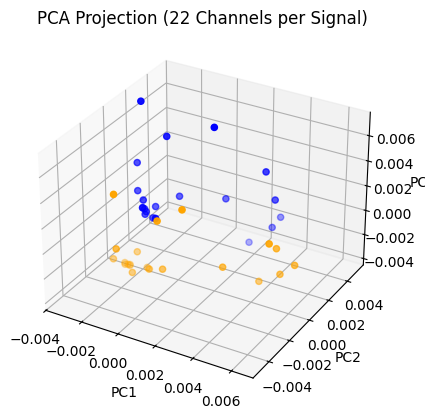

In [65]:
PCA_option_2(mean_signal_sample, 1, 4, 22).to_plot_3D_scatter()

K-means Accuracy: 0.50


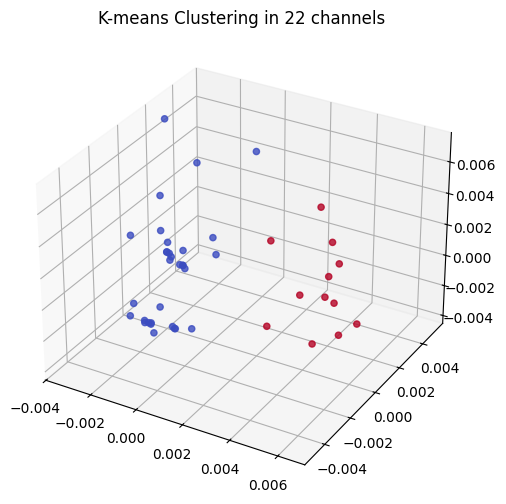

In [66]:
PCA_option_2(mean_signal_sample, 1, 4, 22).to_plot_KMean()
# acc,_=PCA_option_2(mean_signal_sample, 1, 4, 10).to_apply_KMean()


In [72]:
PCA_option_2(mean_signal_sample, 1, 4, 22).to_apply_KMean()

K-means Accuracy: 0.50
[0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0
 1 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


(0.5,
 array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]))

[1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5217391304347826, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5166666666666667, 0.5645161290322581, 0.515625]


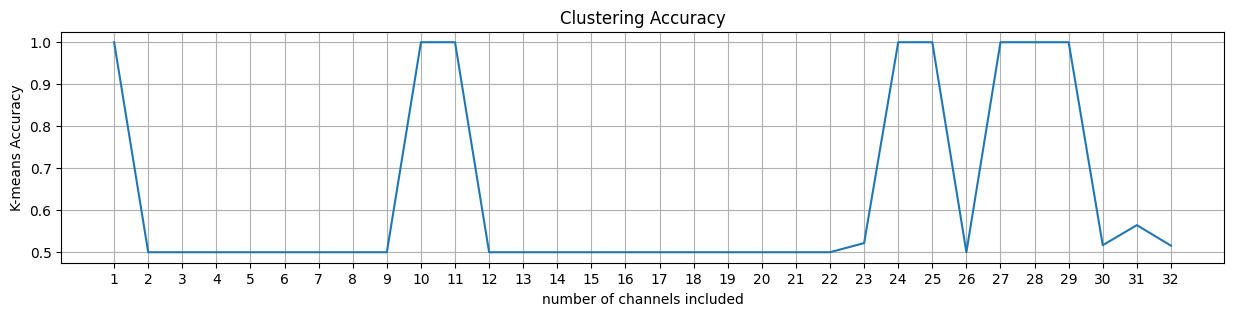

In [82]:
acc_cluster = []
for ch in range(1,33):
    accuracy,_ = PCA_option_2(mean_signal_sample, 1, 4, ch).to_apply_KMean()
    acc_cluster.append(accuracy)
print(acc_cluster)
    
plt.figure(figsize=(15,3))    
    
plt.plot(range(1,33), acc_cluster)
plt.xticks(range(1, 33))  # Tick every 1 unit from 1 to 32
plt.xlabel('number of channels included')
plt.ylabel('K-means Accuracy')
plt.title('Clustering Accuracy')
plt.grid(True)
plt.show() 
    
    